In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리 라이브러리
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU를 사용하되, 이용가능하지 않으면 cpu 사용

fashion_mnist 데이터셋 내려받기

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('/content/FashionMNIST_data', download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('/content/FashionMNIST_data', download=True,
                                                  train=False, transform = transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 16563683.81it/s]


Extracting /content/FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301715.76it/s]


Extracting /content/FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5526866.85it/s]


Extracting /content/FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17096022.95it/s]

Extracting /content/FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST_data/FashionMNIST/raw



fashion_mnist 데이터를 데이터 로더에 전달

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

분류에 사용될 클래스 정의

In [ ]:
np.random.randint(3)

0

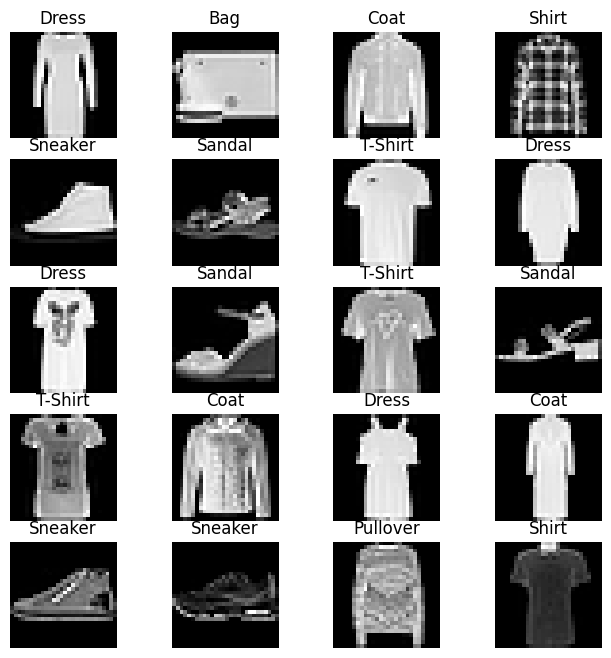

In [ ]:
labels_map = {0: 'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize = (8,8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

심층신경망(DNN) 모델 생성

In [ ]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 784, out_features = 256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

심층신경망에 필요한 파라미터(손실함수, 학습률, 옵티마이저) 정의

In [ ]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()  # 손실함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


심층신경망을 이용한 모델 학습

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []
for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):  #count를 50으로 나누었을 때 나머지가 0이면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count%500):
      print(f"Iteration : {count}, Loss : {loss.data}%, Accuracy : {accuracy}%")


Iteration : 500, Loss : 0.535679042339325%, Accuracy : 83.12000274658203%
Iteration : 1000, Loss : 0.47736403346061707%, Accuracy : 84.7699966430664%
Iteration : 1500, Loss : 0.3535648286342621%, Accuracy : 84.95999908447266%
Iteration : 2000, Loss : 0.3688396215438843%, Accuracy : 85.43000030517578%
Iteration : 2500, Loss : 0.25591808557510376%, Accuracy : 85.73999786376953%
Iteration : 3000, Loss : 0.23220092058181763%, Accuracy : 86.43000030517578%


합성곱 신경망 생성

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features = 64*6*6, out_features = 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

합성곱 신경망을 위한 파라미터 정의

In [ ]:
learning_late = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_late)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


모델 학습 및 성능 평가

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []
for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):  #count를 50으로 나누었을 때 나머지가 0이면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count%500):
      print(f"Iteration : {count}, Loss : {loss.data}%, Accuracy : {accuracy}%")


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 500, Loss : 0.4729856550693512%, Accuracy : 86.47000122070312%
Iteration : 1000, Loss : 0.31272953748703003%, Accuracy : 87.93000030517578%
Iteration : 1500, Loss : 0.3921777009963989%, Accuracy : 87.0199966430664%
Iteration : 2000, Loss : 0.22013498842716217%, Accuracy : 88.55000305175781%
Iteration : 2500, Loss : 0.1653842329978943%, Accuracy : 89.55000305175781%
Iteration : 3000, Loss : 0.18400241434574127%, Accuracy : 90.13999938964844%
